In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.impute import KNNImputer
from src.utils import *
from sklearn.preprocessing import StandardScaler
import random

random.seed(7)

## Preprocessing

In [10]:
# read in data from RS
olink_rs = pd.read_csv("Data/RS/RS_olink_beforeQC.csv", sep = ";", low_memory=False)
olink_rs_samples = olink_rs.loc[olink_rs['Sample_Type'] == 'SAMPLE']
olink_rs['Assay_Warning'].value_counts()

Assay_Warning
PASS        418824
EXCLUDED      3324
Name: count, dtype: int64

In [11]:
excluded = olink_rs.loc[olink_rs['Assay_Warning'] == 'EXCLUDED']
excluded['Assay'].value_counts() #If Assay_Warning NPX is NaN

Assay
BMP6       1108
EPHX2      1108
PGLYRP1    1108
Name: count, dtype: int64

In [12]:
olink_rs.columns

Index(['SampleID', 'Sample_Type', 'Index', 'OlinkID', 'UniProt', 'Assay',
       'MissingFreq', 'Panel', 'Panel_Lot_Nr', 'Block', 'PlateID', 'WellID',
       'Count', 'QC_Warning', 'LOD', 'NPX', 'Normalization', 'Assay_Warning',
       'IntraCV', 'InterCV', 'Processing_StartDate', 'Processing_EndDate',
       'AnalyzerID', 'ExploreVersion'],
      dtype='object')

In [13]:
# create participants by protein table
olink_rs_ap = olink_rs_samples.pivot(columns = 'Assay',  values = "NPX",  index = "SampleID") 

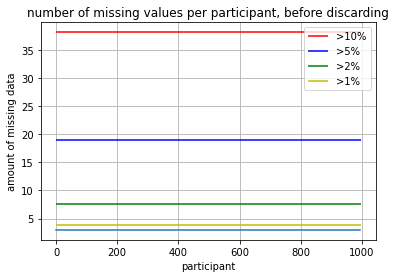

In [14]:
nan_part = olink_rs_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

plt.plot(np.arange(len(nan_part)), nan_part.values)
plt.xlabel("participant")
plt.ylabel("amount of missing data")
plt.grid()
plt.hlines(olink_rs_ap.shape[1] * 0.10, 0, olink_rs_ap.shape[0], label = ">10%", color = "r")
plt.hlines(olink_rs_ap.shape[1] * 0.05, 0, olink_rs_ap.shape[0], label = ">5%", color = "b")
plt.hlines(olink_rs_ap.shape[1] * 0.02, 0, olink_rs_ap.shape[0], label = ">2%", color = "g")
plt.hlines(olink_rs_ap.shape[1] * 0.01, 0, olink_rs_ap.shape[0], label = ">1%", color = "y")
plt.title("number of missing values per participant, before discarding")
plt.legend()

In [15]:
nan_part.describe()

count    996.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0
dtype: float64

In [16]:
# thresholds for excluding participants/proteins based on amount of nans
t_nan_prot = 0.02
t_nan_part = 0.02


nan_part = olink_rs_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

n_proteins = olink_rs_ap.shape[1]


#first discard participants
excluded_participants = nan_part[nan_part > t_nan_part * n_proteins]
olink_rs_parts_dropped = olink_rs_ap.dropna(axis = 0, thresh = (1 - t_nan_part) * n_proteins)


# count nan values per protein and per participant
nan_prot = olink_rs_parts_dropped.isna().sum()
nan_prot = nan_prot.sort_values(ascending=False)

# then discard proteins
n_participants_left = olink_rs_parts_dropped.shape[0]
excluded_proteins = nan_prot[nan_prot > t_nan_prot * n_participants_left].keys()
olink_rs_nansdropped = olink_rs_parts_dropped.dropna(axis = 1, thresh=(1 - t_nan_prot) * n_participants_left)
# olink_i0_nansdropped = olink_i0_nansdropped.dropna(axis = 0, thresh = (1 - t_nan_part) * n_proteins)

print(f'amount of proteins excluded :{len(excluded_proteins)}')
print(f'amount of participants excluded :{len(excluded_participants)}')

amount of proteins excluded :3
amount of participants excluded :0


In [17]:
_, _, _, _, _, _, colscmb = get_data({'dset': 'cmb', 'target': 'mort', 'add_age':0, 'combine_sets':False})

In [23]:
colsforlls = colscmb[:-1]
pd.Series(colsforlls,index=colsforlls).to_csv('./Data/Processed/cmbproteins.csv', header=False, index=False)

In [61]:
list(set(excluded_proteins) & set(colscmb))
#Looked up highest correlatio in UKBB
#BMP6 = PDGFA
#EPHX2 = GSTA1
#PGLYRP1 = RETN

['PGLYRP1', 'BMP6', 'EPHX2']

In [62]:
## impute data for other missing values
n_n = 5
imputer = KNNImputer(n_neighbors = n_n)
olink_rs_ap_imputed = imputer.fit_transform(olink_rs_nansdropped)

In [63]:
proteins_imputed_df = pd.DataFrame(data = olink_rs_ap_imputed, columns = olink_rs_nansdropped.columns, index = olink_rs_nansdropped.index)
proteins_imputed_df.shape
proteins_imputed_df['BMP6'] = proteins_imputed_df['PDGFA']
proteins_imputed_df['EPHX2'] = proteins_imputed_df['GSTA1']
proteins_imputed_df['PGLYRP1'] = proteins_imputed_df['RETN']
proteins_imputed_df = proteins_imputed_df[colscmb[:-1]]
proteins_imputed_df

scaler = StandardScaler()      
proteins_imputed_array = scaler.fit_transform(proteins_imputed_df)
proteins_save_df = pd.DataFrame(proteins_imputed_array, columns = colscmb[:-1], index = proteins_imputed_df.index)
proteins_save_df.to_csv('Data/RS/RS_olink_imputed.csv')

In [64]:
proteins_save_df

,ACAN,ACE2,ACOX1,ACP5,ACTA2,ACY1,ADA2,ADAM15,ADAMTS13,ADAMTS16,...,VAMP5,VASN,VCAM1,VIM,VSIR,VSTM2L,VWF,WASF1,XG,ZBTB17
SampleID,,,,,,,,,,,,,,,,,,,,,
10075,3.295059,1.349763,0.141638,-1.055709,1.762724,-1.480845,0.811556,0.157288,-2.303159,1.698962,...,-0.419277,1.786283,2.674729,-0.085394,2.480066,-1.220065,-0.166004,0.630416,2.276444,1.381987
10127,1.767077,1.102034,-0.274665,1.473642,0.977942,-0.848517,3.522835,-0.346106,-2.607331,2.736139,...,1.885059,-0.241724,2.267510,0.781373,1.254043,-0.362101,2.170380,-0.609770,0.746194,0.639024
10164,-1.126221,-0.482621,-0.175365,-0.402545,1.461407,-0.980016,1.469980,-0.560292,-0.920172,0.775057,...,-0.061176,-0.332236,1.914158,-0.572898,-0.296780,-0.790159,0.365598,-0.108223,0.598529,0.077356
10171,-0.015901,0.737173,0.016674,-0.139984,0.809097,-1.351057,0.412292,2.336524,0.295244,0.601908,...,-0.102485,0.822081,0.733907,-0.304436,0.052934,-2.015861,1.316611,0.089623,1.662536,0.677587
10229,1.634079,1.640911,0.361966,-0.585197,1.455038,0.640955,1.728521,-0.364234,-0.371220,1.294122,...,-0.185677,1.171254,1.705122,0.625138,1.544589,0.437918,1.065217,-0.424165,0.606709,0.905208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9427,-2.024877,-0.682049,0.167448,-0.549407,-0.314648,-0.036233,-1.127813,-1.224884,0.461117,-0.657616,...,-0.938292,0.344902,-0.494181,-0.630293,-1.585397,-0.421367,-1.644476,-1.248316,-1.319395,-0.068382
9434,-0.793892,-0.215370,0.002822,-0.315539,0.248074,-0.241188,-0.191865,1.970344,-0.795449,0.684859,...,-0.365591,0.238863,1.699092,0.242741,0.743330,-0.001228,0.939520,-0.154129,0.311163,-0.112704
9439,1.395748,-0.573836,-0.119226,-0.192126,-0.147926,-0.486551,-0.709154,0.510082,-1.458095,-0.275659,...,-0.533990,1.076954,-0.465238,0.891463,0.899036,-0.537654,-0.035624,0.673981,2.102733,0.804794
